In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from torch.optim import AdamW

c:\My_Files\Data_Science\Intermediate\Sentiment_Analyzer\Model_Creation\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('Dataset/sentiment_data.csv')

In [3]:
df.head(5)

,Unnamed: 0,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,1
1,1,nz retailers don’t even contactless credit car...,0
2,2,forever acknowledge channel help lessons ideas...,2
3,3,whenever go place doesn’t take apple pay doesn...,0
4,4,apple pay convenient secure easy use used kore...,2


In [4]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.head(5)

,Comment,Sentiment
0,lets forget apple pay required brand new iphon...,1
1,nz retailers don’t even contactless credit car...,0
2,forever acknowledge channel help lessons ideas...,2
3,whenever go place doesn’t take apple pay doesn...,0
4,apple pay convenient secure easy use used kore...,2


In [6]:
df.shape

(241145, 2)

In [7]:
df.isnull().sum()

Comment      217
Sentiment      0
dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.isnull().sum()

Comment      0
Sentiment    0
dtype: int64

In [10]:
sentiment_counts = df['Sentiment'].value_counts()

In [11]:
sentiment_counts

Sentiment
2    103046
1     82777
0     55105
Name: count, dtype: int64

C:\Users\sulav\AppData\Local\Temp\ipykernel_1924\2040272853.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


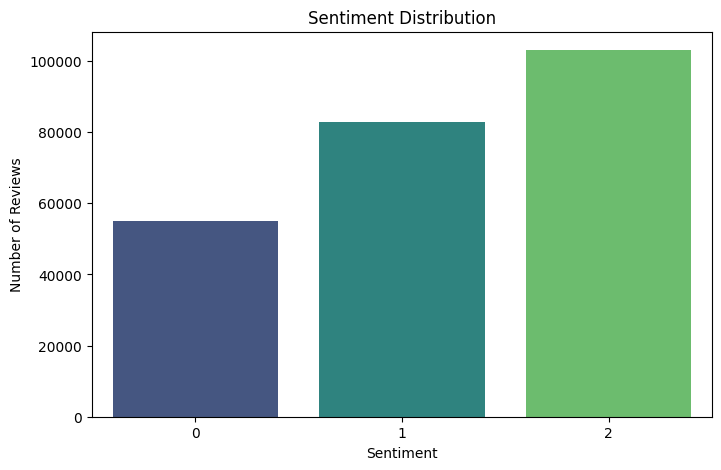

In [12]:
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [13]:
df.head(5)

,Comment,Sentiment
0,lets forget apple pay required brand new iphon...,1
1,nz retailers don’t even contactless credit car...,0
2,forever acknowledge channel help lessons ideas...,2
3,whenever go place doesn’t take apple pay doesn...,0
4,apple pay convenient secure easy use used kore...,2


In [14]:
def has_html(text):
    html_pattern = re.compile(r'<.*?>')
    return bool(html_pattern.search(text))

In [15]:
df['has_html'] = df['Comment'].apply(has_html)

In [16]:
df['has_html'].value_counts()

has_html
False    240928
Name: count, dtype: int64

In [17]:
def has_emoji(text):
    return bool(emoji.emoji_list(str(text)))

In [18]:
df['has_emoji'] = df['Comment'].apply(has_emoji)

In [19]:
df['has_emoji'].value_counts()

has_emoji
False    240410
True        518
Name: count, dtype: int64

In [20]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    return text

In [21]:
df['cleaned_comment'] = df['Comment'].apply(clean_text)

In [22]:
df['has-emoji2'] = df['cleaned_comment'].apply(has_emoji)

In [23]:
df['has-emoji2'].value_counts()

has-emoji2
False    240928
Name: count, dtype: int64

In [24]:
df.head(5)

,Comment,Sentiment,has_html,has_emoji,cleaned_comment,has-emoji2
0,lets forget apple pay required brand new iphon...,1,False,False,lets forget apple pay required brand new iphon...,False
1,nz retailers don’t even contactless credit car...,0,False,False,nz retailers don’t even contactless credit car...,False
2,forever acknowledge channel help lessons ideas...,2,False,False,forever acknowledge channel help lessons ideas...,False
3,whenever go place doesn’t take apple pay doesn...,0,False,False,whenever go place doesn’t take apple pay doesn...,False
4,apple pay convenient secure easy use used kore...,2,False,False,apple pay convenient secure easy use used kore...,False


In [25]:
df.drop(columns=['has_html', 'has_emoji', 'has-emoji2'], inplace=True)

In [26]:
df.drop(columns=['Comment'], inplace=True)

In [27]:
df.head(5)

,Sentiment,cleaned_comment
0,1,lets forget apple pay required brand new iphon...
1,0,nz retailers don’t even contactless credit car...
2,2,forever acknowledge channel help lessons ideas...
3,0,whenever go place doesn’t take apple pay doesn...
4,2,apple pay convenient secure easy use used kore...


In [28]:
text = df['cleaned_comment'].tolist()
labels = df['Sentiment'].tolist()

In [29]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [30]:
max_length = 128
encodings = tokenizer(
    text,
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors='pt'
)

In [31]:
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
labels_tensor = torch.tensor(labels)

In [32]:
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels_tensor, test_size=0.2, random_state=42, stratify=labels_tensor
)

In [33]:
train_dataet = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

In [34]:
batch_size = 16

In [35]:
train_dataloader = DataLoader(
    train_dataet,
    sampler=RandomSampler(train_dataet),
    batch_size=batch_size
)

In [36]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

In [37]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [39]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

In [40]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()

In [45]:
from tqdm import tqdm

epochs = 1

for epoch in range(epochs):
    model.train()  # set model to training mode
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()

        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} finished. Average Loss: {avg_loss:.4f}")

Training Epoch 1: 100%|██████████| 12047/12047 [1:04:15<00:00,  3.12it/s]

Epoch 1 finished. Average Loss: 0.4607


In [46]:
from sklearn.metrics import accuracy_score

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch)

        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())

acc = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8662


In [51]:
def predict_sentiment(text):
    model.eval()
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**tokens)
        pred = torch.argmax(outputs.logits, dim=1).item()
    if pred == 0:
        return "Negative"
    elif pred == 1:
        return "Neutral"
    else:
        return "Positive"

print(predict_sentiment("I really love this movie!"))
print(predict_sentiment("This was the worst experience ever."))

Positive
Negative


In [41]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else None)
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

CUDA available: True
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
device

device(type='cuda')

In [44]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [55]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [56]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", cm)

Accuracy: 0.866205951936247
Precision: 0.8665257368370674
Recall: 0.866205951936247
F1-score: 0.8656873952988487
Confusion Matrix:
 [[ 8613  1241  1167]
 [  721 14668  1167]
 [  632  1519 18458]]


In [57]:
# Save fine-tuned model, tokenizer, and training checkpoint
import os, json, datetime
from pathlib import Path
save_dir = Path("saved_models/bert-sentiment")
save_dir.mkdir(parents=True, exist_ok=True)

# Optional: define consistent label maps for export
id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
label2id = {v: k for k, v in id2label.items()}

# Attach label maps to model config before saving (helps downstream use)
model.config.id2label = id2label
model.config.label2id = label2id

# Save model weights and config
model.save_pretrained(save_dir.as_posix())
tokenizer.save_pretrained(save_dir.as_posix())

# Also save a training checkpoint (optional)
ckpt = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict() if 'optimizer' in globals() else None,
    "epoch": epochs if 'epochs' in globals() else None,
    "timestamp": datetime.datetime.now().isoformat(),
}
torch.save(ckpt, (save_dir / "checkpoint.pt").as_posix())

# Save a small README with usage tips
readme_text = """This folder contains a fine-tuned BERT model for 3-class sentiment (Negative/Neutral/Positive).\n\n
Load with:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    tok = AutoTokenizer.from_pretrained('<path>')
    mdl = AutoModelForSequenceClassification.from_pretrained('<path>')
"""
(save_dir / "README.txt").write_text(readme_text)
print(f"Saved to: {save_dir.resolve()}")

Saved to: C:\My_Files\Data_Science\Intermediate\Sentiment_Analyzer\Model_Creation\saved_models\bert-sentiment


In [58]:
# Reload the saved model/tokenizer and run a quick check
from transformers import AutoModelForSequenceClassification
reload_dir = "saved_models/bert-sentiment"
tok2 = AutoTokenizer.from_pretrained(reload_dir)
mdl2 = AutoModelForSequenceClassification.from_pretrained(reload_dir).to(device)
mdl2.eval()

sample_texts = [
    "I loved the product, works great!",
    "It's okay, nothing special.",
    "Terrible quality, very disappointed.",
]
batch = tok2(sample_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
with torch.no_grad():
    out = mdl2(**batch)
preds = out.logits.argmax(dim=1).tolist()
labels_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
print([labels_map[p] for p in preds])

['Positive', 'Neutral', 'Negative']
